### Colab Setup

<a href="https://colab.research.google.com/github/iakioh/MusiCAN/blob/main/models/first_music_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')  

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Go to this notebook's directory
%cd {repo_path}/models

/content/drive/MyDrive/Uni/MusiCAN/models


In [4]:
# Check GPU connection
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Sep  8 12:37:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# Check RAM access
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# musiGAN

**Description:** 1-Track MuseGAN architecture build on MiniGAN.\
**Purpose:** implement a composing GAN.\
**Results:**

In [6]:
import pickle
from tqdm import notebook
import datetime
from IPython.display import Audio, display

import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

import math
import numpy as np
import torch

import muspy
import fluidsynth

## Data Preparation

In [8]:
class Pianoroll :
    def __init__ (self, filepath) :
        assert  type(filepath) == str

        # Creating the dataset from a file
        stored_data = np.load(filepath)
        data_array  = stored_data["data"]
        labels_array = stored_data["labels"]
        self.data   = torch.as_tensor(data_array, dtype = torch.float32)
        self.labels = torch.as_tensor(labels_array, dtype = torch.int32)

        self.dataset = torch.utils.data.TensorDataset(self.data, self.labels)

        # Storing additional info about it
        self.shape  = tuple(self.data.shape[1:])   # shape of one pianoroll image
        self.size   = self.shape[0] * self.shape[1]
        self.height       = self.data.shape[2]
        self.width        = self.data.shape[1]
        self.dataset_size = self.data.shape[0]

    
    def show (self, number = None) :
        if number == None :
            number = np.random.randint(self.dataset_size)
        else :
            assert  type(number) == int
            assert  number >= 0 and number < self.dataset_size

        plt.figure(figsize = (12, 6))
        plt.title(f"pianoroll #{number}")
        plt.imshow(self.data[number].T)
        plt.show()    

### LPD5

In [ ]:
lpd5 = Pianoroll("../data_preparation/prepared_data/lpd5_full_4bars/prepared_arrays.npz")

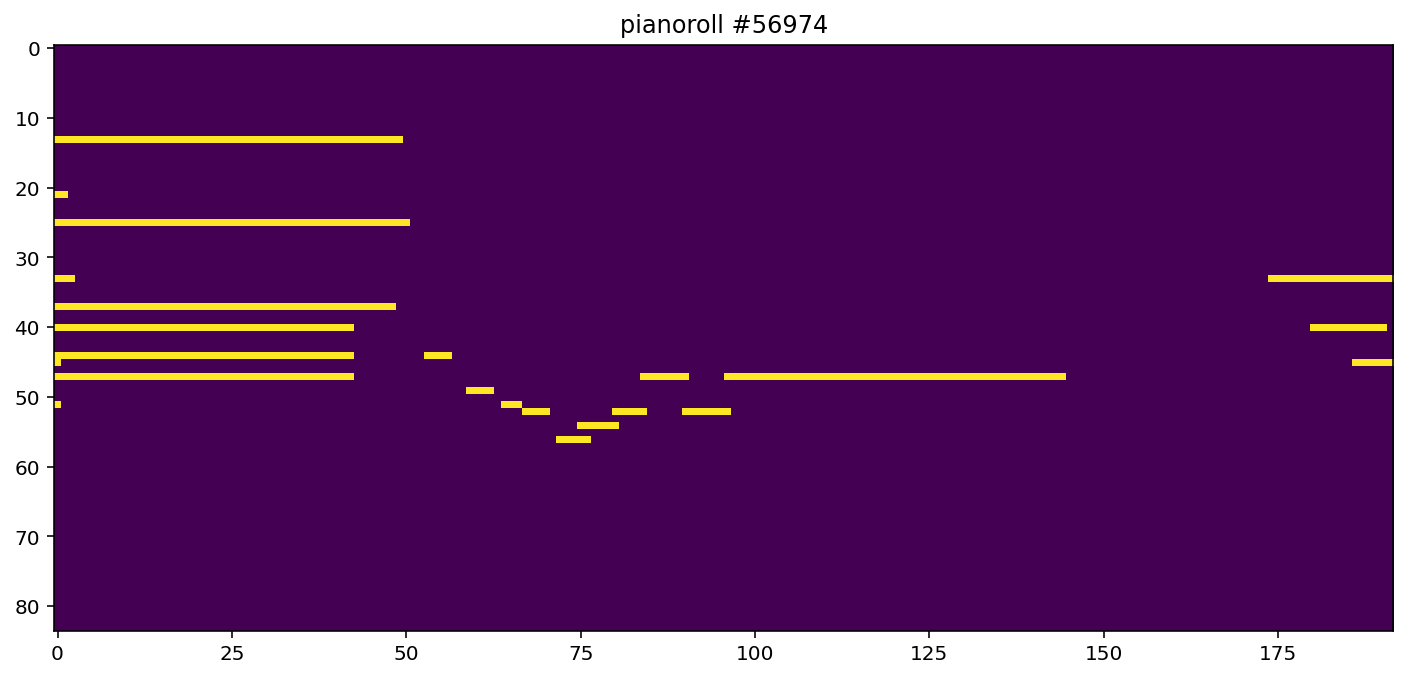

lpd5.dataset_size 102483
lpd5.shape (192, 84)


In [ ]:
lpd5.show()
print("lpd5.dataset_size", lpd5.dataset_size)
print("lpd5.shape", lpd5.shape)

In [ ]:
lpd5.bars           = 4
lpd5.lowest_pitch   = 24
lpd5.blips_per_bar  = lpd5.width // lpd5.bars
lpd5.blips_per_beat = lpd5.blips_per_bar // 4
lpd5.pitches        = lpd5.height
lpd5.octaves        = lpd5.pitches // 12

print("lpd5.blips_per_bar", lpd5.blips_per_bar)
print("lpd5.pitches", lpd5.pitches)

lpd5.blips_per_bar 48
lpd5.pitches 84


## Architecture classes

### Support classes

In [9]:
"""
    These two classes serves as torch layers to binarize the output of the Generator while keeping the layer still "backpropagatable" (via a hardtanh).
    This is not our own code. For source, see:
    https://www.hassanaskary.com/python/pytorch/deep%20learning/2020/09/19/intuitive-explanation-of-straight-through-estimators.html#:~:text=A%20straight%2Dthrough%20estimator%20is,function%20was%20an%20identity%20function.
"""

class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return torch.nn.functional.hardtanh(grad_output)

class StraightThroughEstimator(torch.nn.Module):
    def __init__(self):
        super(StraightThroughEstimator, self).__init__()

    def forward(self, x):
        x = STEFunction.apply(x)
        return x


In [ ]:
class GeneratorBlock(torch.nn.Module):
    """ 2d transconv layer, batch normalization & ReLU """

    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()

        self.gen_block = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_dim, out_dim, kernel, stride),
            torch.nn.BatchNorm2d(out_dim),
            torch.nn.ReLU()
            )

    def forward(self, x):
        return self.gen_block(x)

In [ ]:
class DiscriminatorBlock(torch.nn.Module):
    """3d conv layer & Leaky ReLU"""

    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.dis_block = torch.nn.Sequential(
            torch.nn.Conv3d(in_dim, out_dim, kernel, stride),
            torch.nn.LeakyReLU(negative_slope = 0.2)   # MuseGAN Hyperparameter
            )

    def forward(self, x):
        return self.dis_block(x)

### Main neural network classes

In [ ]:
class MusiGen (torch.nn.Module) :
    """
    1-track museGAN generator, consisting of two sub-networks (so-called 
    temporal and bar generator)

    input : seed vector, a normally distributed random vector, 
            length: (B + 1) * 64 = 5 * 64 here
    output: pianaroll, binary tensor, shape: (B x T x P) = (4 x 48 x 84) here
    """

    def __init__ (self, log = False, **kwargs) : 
        super().__init__(**kwargs)

        # Data parameters
        self.octaves    = lpd5.octaves
        self.bars       = lpd5.bars    # bars per pianoroll
        self.T          = lpd5.blips_per_bar  # timesteps per bar
        self.P          = lpd5.pitches   # pitches
        self.seedlength = 64
        
        self.temporal_generator = torch.nn.Sequential(
            
            # heuristically added linear layer
            torch.nn.Linear(1, 31),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),

            # transconv layer 1
            torch.nn.ConvTranspose1d(64, 1024, 2, 2),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(),

            # transconv layer 2
            torch.nn.ConvTranspose1d(1024, 1, 3, 1),
            torch.nn.BatchNorm1d(1),
            torch.nn.ReLU()
        )

        self.bar_generator = torch.nn.Sequential(
            
            # transconv layers
            GeneratorBlock( 128, 1024, (2, 1), (2, 1)),
            GeneratorBlock(1024,  512, (2, 1), (2, 1)),
            GeneratorBlock( 512,  256, (2, 1), (2, 1)),
            GeneratorBlock( 256,  256, (2, 1), (2, 1)),
            #GeneratorBlock( 256,  256, (2, 1), (2, 1)),   # add for 96x72 lpd5
            GeneratorBlock( 256,  128, (3, 1), (3, 1)),
            GeneratorBlock( 128,   64, (1, self.octaves), (1, self.octaves)),

            # last layer with tanh & binarization activation fct.s
            torch.nn.ConvTranspose2d(64, 1, (1, 12), (1, 12)),
            torch.nn.BatchNorm2d(1),
            #torch.nn.Tanh(),
            StraightThroughEstimator() # binarization
        )

        if log :
            print(f"Generator: parameters: {self.count_params()}")
            print("")

    def count_params (self) :
        """count number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


    def forward_custom (self, seed) :
        assert  type(seed) == torch.Tensor
        assert  len(seed.shape) == 2
        assert  seed.shape[0] >= 1
        assert  seed.shape[1] == (1 + self.bars) * self.seedlength

        batchsize = seed.shape[0]
        return self.forward(batchsize, seed)


    def forward (self, batch_size, seed = None) :
        if seed == None :
            assert type(batch_size) == int
            assert batch_size >= 1
            
            device = 'cuda'  if torch.cuda.is_available() else  'cpu'
            seed = torch.normal(0., 1, (batch_size, (1 + self.bars) * self.seedlength)).to(device)
            
        seeds = torch.chunk(seed, chunks = 5, dim = 1)
        
        # create time-independent first half of seed for bar generator
        bar_seed_1 = seeds[0]
        bar_seed_1 = bar_seed_1.view((-1, self.seedlength, 1, 1)) # reshape for transconv layers

        # generate pianorolls bar by bar
        generated_bars = []
        for temporal_seed in seeds[1:]:
            
            ## generate time-dependent second half of seed for bar generator

            temporal_seed = temporal_seed.view(-1, self.seedlength, 1) # reshape for transconv layers
            #print(f"temporal seed: {temporal_seed.size()}")
            bar_seed_2 = self.temporal_generator(temporal_seed) # (batch size x 1 x 64)
            #print(f"bar seed 2: {bar_seed_2.size()}")

            ## reshape & concatenate both halfs of seed for bar generator 
            
            bar_seed_2 = bar_seed_2.view(-1, self.seedlength, 1, 1)
            bar_seed   = torch.cat((bar_seed_1, bar_seed_2), dim = 1) # (batch size x 128 x 1 x 1)
            #print(f"bar seed: {bar_seed d.size()}")

            ## generate one bar 
            
            generated_bar = self.bar_generator(bar_seed) # (batch size x 1 x 48 x 84)
            #print(f"generated_bar: {generated_bar.size()}")
            generated_bars.append(generated_bar) 

        pianoroll = torch.cat(generated_bars, dim = 1) # (batch size x 4 x 48 x 84) 
        #print(f"gen output: {pianoroll.size()}")

        return pianoroll

In [ ]:
class MusiDis (torch.nn.Module) :
    """
    1-Track museGAN discriminator
    
    input : (B x T x P) binary pianoroll
    output: single number, prob. that the input pianoroll is a 
            real and not generated
    """


    def __init__ (self, log = False, **kwargs) :
        super().__init__(**kwargs)

        # Data parameters
        self.octaves    = lpd5.octaves
        self.bars       = lpd5.bars    # bars per pianoroll
        self.T          = lpd5.blips_per_bar  # timesteps per bar
        self.P          = lpd5.pitches   # pitches
        self.seedlength = 64
      
        # conv layers
        self.discriminator_conv = torch.nn.Sequential(
            DiscriminatorBlock(  1, 128, (2, 1,  1), (1, 1,  1)),
            DiscriminatorBlock(128, 128, (3, 1,  1), (1, 1,  1)),
            DiscriminatorBlock(128, 128, (1, 1, 12), (1, 1, 12)), 
            DiscriminatorBlock(128, 128, (1, 1,  self.octaves), (1, 1,  self.octaves)),
            DiscriminatorBlock(128, 128, (1, 2,  1), (1, 2,  1)),
            DiscriminatorBlock(128, 128, (1, 2,  1), (1, 2,  1)),
            #DiscriminatorBlock(128, 128, (1, 5,  1), (1, 5,  1)),   # for 96x72 lpd5
            DiscriminatorBlock(128, 256, (1, 4,  1), (1, 2,  1)),
            DiscriminatorBlock(256, 512, (1, 3,  1), (1, 2,  1))
            )
        
        # fully-connected layers
        self.discriminator_fc = torch.nn.Sequential(
            torch.nn.Linear(512*2, 1024),  # remove "*2" for 96x72 
            torch.nn.LeakyReLU(negative_slope = 0.2),
            torch.nn.Linear(1024, 1))
        
        if log :
            print(f"Discriminator parameters: {self.count_params()}")
            print("")

    def count_params (self) :
        """count number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward (self, pianoroll):
        pianoroll   = pianoroll.view(-1, 1, self.bars, self.T, self.P) # reshape for transconvs
        #print("dis input prep.", pianoroll.shape)
        conv_output = self.discriminator_conv(pianoroll)
        #print("dis conv out", conv_output.size())
        fc_input = conv_output.view(-1, 512*2)  # remove "*2" for 96x72 
        judgement = self.discriminator_fc(fc_input).flatten().float()
        #print("dis out ", judgement.shape)
        return judgement

## Training & evaluation classes

### Training support

In [77]:
def generator_goodness (generated_batch, real_batch) :
    """
        compare two batches of data by calculating the absolute mean difference
    """
    
    # equalize shapes
    real_shape = real_batch.shape[-2:]
    generated_batch = generated_batch.view(-1, *real_shape)
    assert  generated_batch.shape == real_batch.shape

    # averaged over batches 
    generated_mean = torch.mean(generated_batch, dim = 0)
    real_mean      = torch.mean(real_batch, dim = 0)

    # take differnece & absolut value, average over features lastly
    goodness_criteria = torch.mean(torch.abs(real_mean - generated_mean))

    return goodness_criteria.cpu().detach().numpy()

In [14]:
class Log :
    """
        container class for GANTraining logs
    """
    
    def __init__ (self) :
        self.losses       = None
        self.probs        = None
        self.gen_goodness = None
        self._dis_losses  = None
        self._probs       = None

### GANTraining

In [105]:
class GANTraining :
    """
        general GAN training class
        How To Use:
        * `MyTrain = GANTraining(<Generator>, <Discriminator>, <torch_dataset>)`
        * `MyTrain.setup(<int_rounds>, batchsize = 1, discriminator_rounds = 1,     
                        loss_function = ["WGAN", "GAN"])`
        * `MyTrain.train()`
        
        After That:
        * `MyTrain.gen` contains trained Generator
        * `MyTrain.dis` contains trained Discriminator
        * `MyTrain.log` contains metrics from each round:
            - .losses       : np.array, shape = (5, rounds)
            - .probs        : np.array, shape = (2, rounds)
            - .gen_goodness : np.array, shape = (rounds,)
    """


    def __init__ (self, Gen, Dis, dataset) :
        # Input checks
        #assert  issubclass(Gen, Generator)
        #assert  issubclass(Dis, Discriminator)
        assert  type(dataset) == torch.utils.data.dataset.TensorDataset
        #assert  Gen().O == Dis().I
        #assert  Dis().O == 1
        #assert  dataset.tensors[0].shape[-1] == Gen().O   # real and gen. data should have the same size

        self.device = 'cuda'  if torch.cuda.is_available() else  'cpu'
        self.training_filepath = "../execution/trained_models/"

        # GAN classes and dataset
        self.GenClass = Gen
        self.DisClass = Dis
        self.dataset  = dataset
        #self.dataset.tensors[0].to(self.device)
        


    def setup (self, rounds, batch_size = 1, discriminator_rounds = 1, 
               loss_function = "WGAN") :
        assert  type(rounds) == int
        assert  rounds >= 1
        assert  type(batch_size) == int
        assert  batch_size >= 1
        assert  type(discriminator_rounds) == int
        assert  discriminator_rounds >= 1
        assert  loss_function in ["GAN", "WGAN"]

        # Training parameters
        self.rounds     = rounds
        self.batch_size = batch_size
        self.dis_rounds = discriminator_rounds
        self.loss       = loss_function

        # Dataloader
        self.data_loader = torch.utils.data.DataLoader(self.dataset,
                                batch_size = self.batch_size, 
                                drop_last = True,
                                shuffle = True)
        self.dataset_size = self.dataset.tensors[0].shape[0]  # number of instances in dataset
        self.batch_count = self.dataset_size // self.batch_size
        self._batch_idx  = self.batch_count 
        
        # Logs
        self.log = Log()
        self.log.losses       = np.zeros((5, self.rounds))
        self.log.probs        = np.zeros((2, self.rounds))
        self.log.gen_goodness = np.zeros((self.rounds,))
        self.log._dis_losses  = torch.zeros((4, self.dis_rounds)).cpu()
        self.log._probs       = torch.zeros((2, self.dis_rounds)).cpu()
        


    def train (self) :
        assert  hasattr(self, "data_loader")  # If test fails, you haven't run set_params()

        print(f"Training")
        self._initialize_GAN()
        for round in notebook.tqdm(range(self.rounds)) :
            for dis_round in range(self.dis_rounds) :
                print(f"Dis. round {dis_round + 1}           ", end="\r")  # print one dot for every dis_round
                
                # Forward propagation
                batch_real = self._get_batch()
                batch_gen  = self.gen.forward(batch_size = self.batch_size)
                print("batch_gen complete     ", end = '\r')
                dis_real = self.dis.forward(batch_real)
                print("dis_real complete      ", end = '\r')
                dis_gen  = self.dis.forward(batch_gen)
                print("dis_gen complete       ", end = '\r')
                self.prob_real = torch.sigmoid(dis_real)
                self.prob_gen  = torch.sigmoid(dis_gen)
                
                # Calculating the Discriminator loss function
                if self.loss == "GAN" :
                    self.loss_real = - torch.mean(torch.log(self.prob_real))
                    self.loss_gen  = - torch.mean(torch.log(1 - self.prob_gen))
                    self.loss_reg  = torch.tensor(0.)
                elif self.loss == "WGAN" :
                    var_gen   = torch.var(dis_gen)
                    var_real  = torch.var(dis_real)
                    self.loss_reg  = torch.where(var_gen > 1, 
                                                 (var_gen - 1)**2, 0) \
                                     + torch.where(var_real > 1, 
                                                   (var_real - 1)**2, 0)
                    self.loss_real = - torch.mean(dis_real)
                    self.loss_gen  = torch.mean(dis_gen)

                self.loss_dis = self.loss_real + self.loss_gen + self.loss_reg
                self._log_all(round, k = dis_round)
                print("loss_dis complete      ", end = '\r')
                
                # Discriminator update
                self.optimizer_dis.zero_grad()
                self.loss_dis.backward(retain_graph = True)
                self.optimizer_dis.step()
                print("dis.backward() complete", end = '\r')


            # Calculating the Generator loss function
            batch_new = self.gen.forward(batch_size = self.batch_size)
            print("batch_gen complete     ", end = '\r')
            dis_new   = self.dis.forward(batch_new)
            print("dis_new complete       ", end = '\r')
                
            if self.loss == "GAN" :
                prob_new = torch.sigmoid(dis_new)
                self.loss_gen = -torch.mean(torch.log(prob_new)) 
            elif self.loss == "WGAN" :
                self.loss_gen = -torch.mean(dis_new)
            self._log_all(round)
            print("loss_gen complete      ", end = '\r')
                
            
            # Generator update
            self.optimizer_gen.zero_grad()
            self.loss_gen.backward()
            self.optimizer_gen.step()
            print("gen.backward() complete", end = '\r')

        # Put GAN in eval mode
        self.gen.eval()
        self.dis.eval()
        print("Training complete. GAN now in eval() mode.")


    def _initialize_GAN (self) :
        """
            Before each training, the Generator and Discriminator will be freshly initialized with new random weights.
        """
        self.gen = self.GenClass().to(self.device)
        self.dis = self.DisClass().to(self.device)
        self.optimizer_gen = torch.optim.Adam(self.gen.parameters(), 
                                              lr = 0.001,
                                              #betas = (0.5, 0.9))
                                              betas = (0.9, 0.99))
        self.optimizer_dis = torch.optim.Adam(self.dis.parameters(), 
                                              lr = 0.00001,
                                              #betas = (0.5, 0.9))
                                              betas = (0.9, 0.99))
        # Note: ADAM parameters from GAN tutorial [1].
        

    def _get_batch (self) :
        """
            samples one batch of data from self.data_loader without replacement.
            When the self.data_set is depleted of fresh batches, 
            self.data_loader will shuffle a list of new batches.
        """
        if self._batch_idx >= self.batch_count :
            self._data_iter = iter(self.data_loader)
            self._batch_idx = 0
        batch = self._data_iter.next()[0].to(self.device)
        self._batch_idx += 1
        return batch   



    def _log_all (self, round, k = -1) :
        if k >= 0 : # before each Discriminator update
            self.log._dis_losses[0, k] = self.loss_dis.cpu().detach()
            self.log._dis_losses[1, k] = self.loss_real.cpu().detach()
            self.log._dis_losses[2, k] = self.loss_gen.cpu().detach()
            self.log._dis_losses[3, k] = self.loss_reg.cpu().detach()
            self.log._probs[0, k] = self.prob_real.mean().cpu().detach()
            self.log._probs[1, k] = self.prob_gen.mean().cpu().detach()
        
        if k == -1 : # before each Generator update
            # Losses
            dis_losses = self.log._dis_losses.cpu().detach().numpy()
            self.log.losses[0:4, round] = dis_losses.mean(axis = 1)
            self.log.losses[4, round]   = self.loss_gen.cpu().detach().numpy()
            
            # Discriminator Probabilities
            probs                    = self.log._probs.cpu().detach().numpy()
            self.log.probs[:, round] = probs.mean(axis = 1)

            # Generator Goodness
            batch_real = self._get_batch()
            batch_gen  = self.gen.forward(batch_size = self.batch_size)
            goodness   = generator_goodness(batch_gen, batch_real)

            self.log.gen_goodness[round] = goodness


    def plot (self) :
        rounds = np.arange(self.rounds) + 1
        plt.suptitle("Training results")
        plt.title("Loss Terms")
        plt.plot(rounds, self.log.losses.T)
        plt.xlabel("round")
        plt.ylim(-6, 6)
        plt.legend(["Discriminator Loss", "Dis. Real Term", "Dis. Gen Term", "Dis. Reg Term", "Generator Loss"])
        plt.show()

        plt.title("Batch-averaged Discriminator Probabilities during Training")
        plt.plot(rounds, self.log.probs.T)
        plt.xlabel("epoch")
        plt.ylim(0,1)
        plt.legend(["real data", "generated data"])
        plt.show()

        plt.title("Generator Goodness during Training")
        plt.plot(rounds, self.log.gen_goodness)
        plt.xlabel("epoch")
        plt.ylim(0,1)
        plt.legend(["Averaged real-generated difference"])
        plt.show()



    def save (self, name) :
        file_name = self.training_filepath + name + ".obj"
        file      = open(file_name, "wb")
        pickle.dump(self, file)
        print(f"Saved training under '{file_name}'")


    def load (self, name) :
        file_name = self.training_filepath + name + ".obj"
        file      = open(file_name, "rb")
        return pickle.load(file)


# Sources:
# [1] https://github.com/salu133445/ismir2019tutorial/blob/main/gan.ipynb

### Evaluation support

In [132]:
def quick_test(generator, discriminator, data, test_size = 10, num_images = 1): 
    
    # Test on generated data
    generator.eval()
    discriminator.eval()
    device = 'cuda'  if torch.cuda.is_available() else  'cpu'
    data_real = iter(torch.utils.data.DataLoader(data.dataset,  # make a batch
                     batch_size = test_size, 
                     shuffle = True, drop_last = True)
                ).next()[0].to(device)
    
    ## Generator
    data_generated = generator.forward(batch_size = test_size)

    ## Discriminator

    gen_judgements  = discriminator.forward(data_generated)
    real_judgements = discriminator.forward(data_real)
    gen_probs       = torch.sigmoid(gen_judgements)
    real_probs      = torch.sigmoid(real_judgements)
    gen_prob        = torch.std_mean(gen_probs, unbiased=True)
    real_prob       = torch.std_mean(real_probs, unbiased=True)
    
    # Discriminator Results
    print(f"Discriminator p(x_real = real) = " +
          f"{real_prob[1]*100:.0f}±{real_prob[0]*100:.0f}%")
    print(f"Discriminator p(x_gen = real)  = " +
          f"{gen_prob[1]*100:.0f}±{gen_prob[0]*100:.0f}%")
    
    # Generator examples
    ## images
    images  = data_generated.cpu().detach().numpy() \
              .reshape(-1, data.height, data.width)
    np.random.shuffle(images)  # shuffles ordering of images 

    
    for i in range(num_images) :
        ## audios
        pianoroll = np.pad(images[i], ((0, 0), 
                                    (data.lowest_pitch, 
                                    128 - data.lowest_pitch - data.height)))   # complete the pitch range
        piano_music = muspy.from_pianoroll_representation(pianoroll > 0,
                        resolution = data.blips_per_beat, 
                        encode_velocity = False)   # convert to muspy.music_object
        timestamp   = datetime.datetime.now()
        filepath    = f"../data_preparation/prepared_data/lpd5_full_4bars/audio_examples/{timestamp}.wav"
        muspy.write_audio(path = filepath, music = piano_music)
        display(Audio(filename = filepath))

        plt.figure(figsize = (12, 6))
        plt.title("Generated example")
        plt.imshow(images[i])
        plt.show()

## Network training and evaluation

Training


  0%|          | 0/1000 [00:00<?, ?it/s]

Training complete. GAN now in eval() mode.


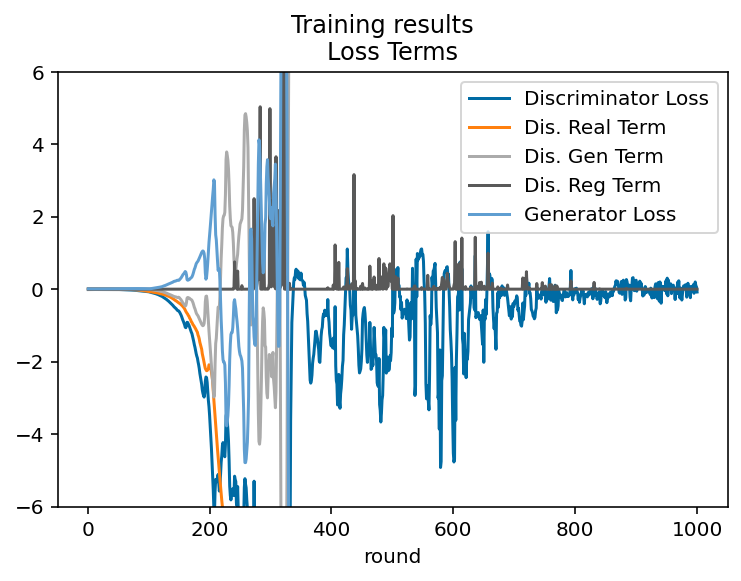

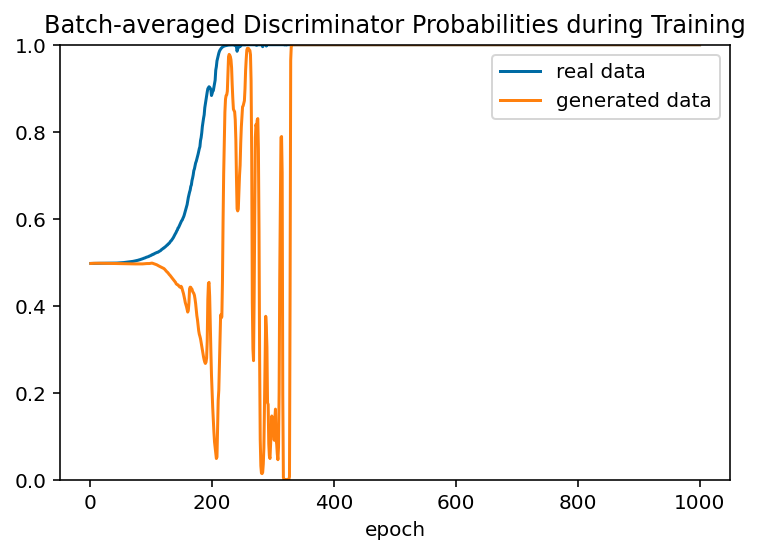

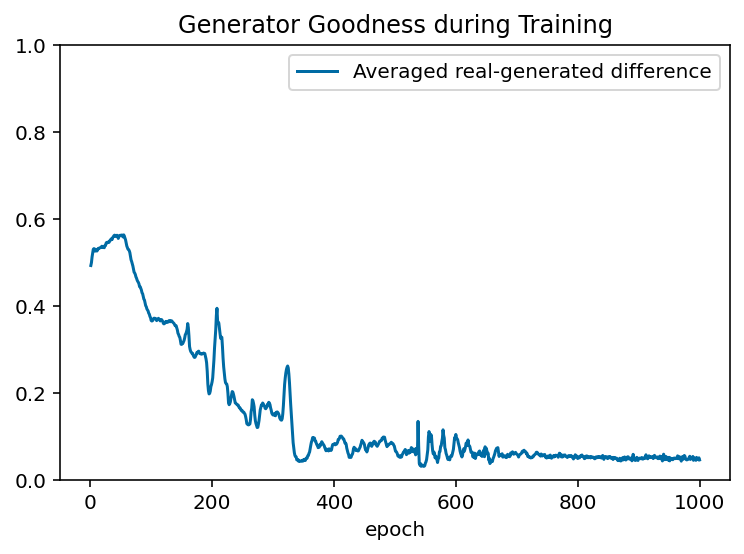

In [106]:
lpd5Train = GANTraining(MusiGen, MusiDis, lpd5.dataset)
lpd5Train.setup(1000, batch_size = 100, discriminator_rounds = 1, loss_function = "WGAN")
lpd5Train.train()
lpd5Train.plot()

Discriminator p(x_real = real) = 100±0%
Discriminator p(x_gen = real)  = 100±0%


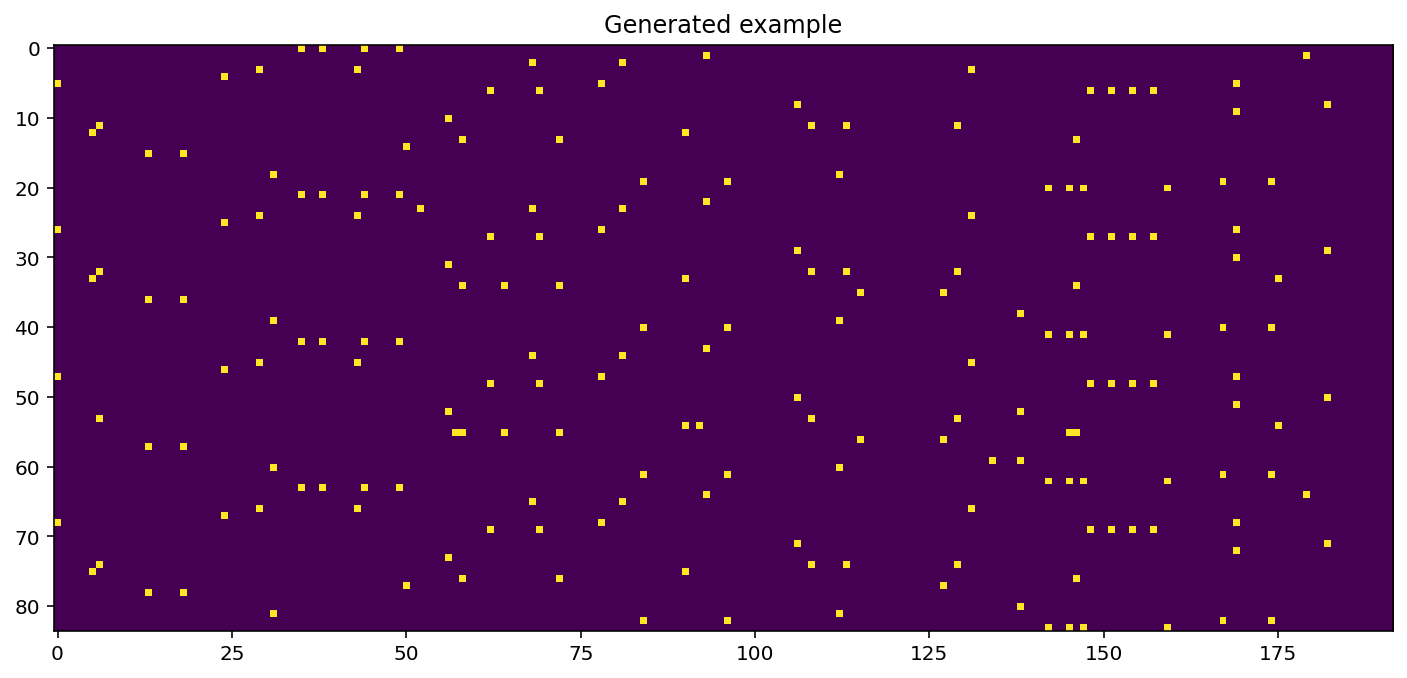

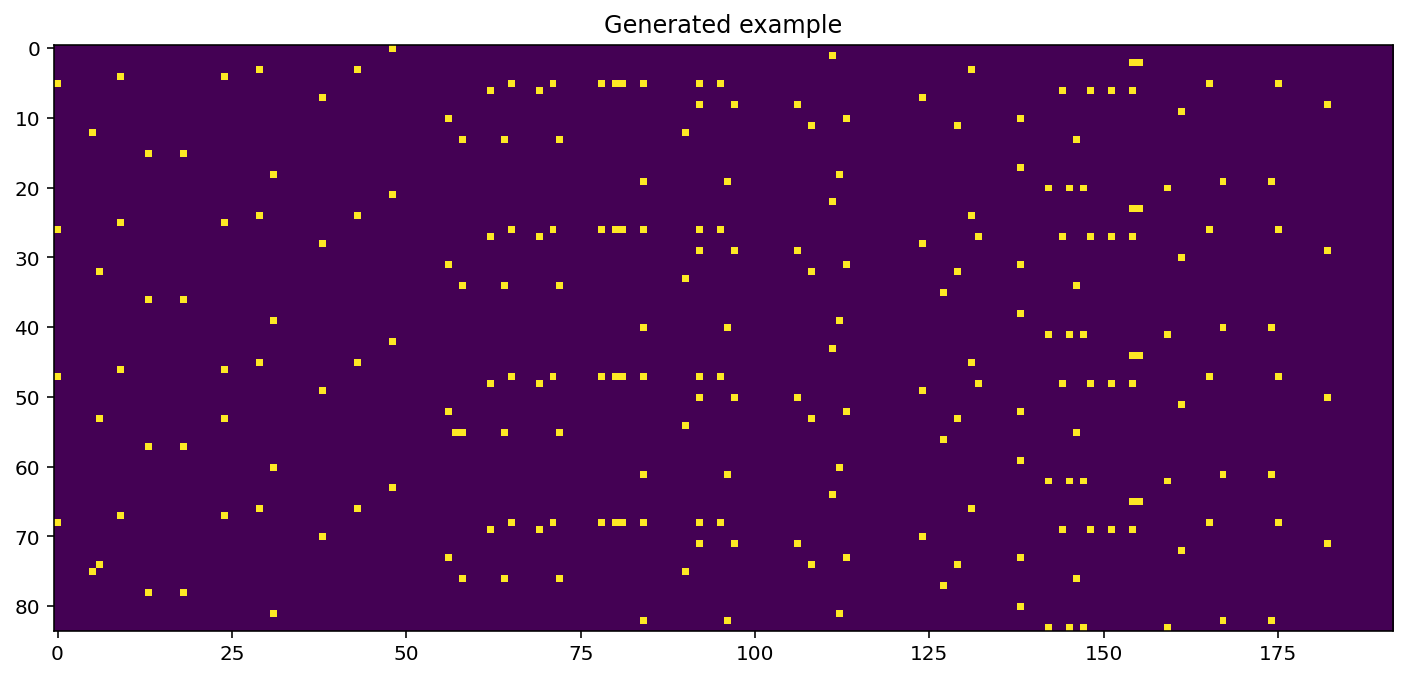

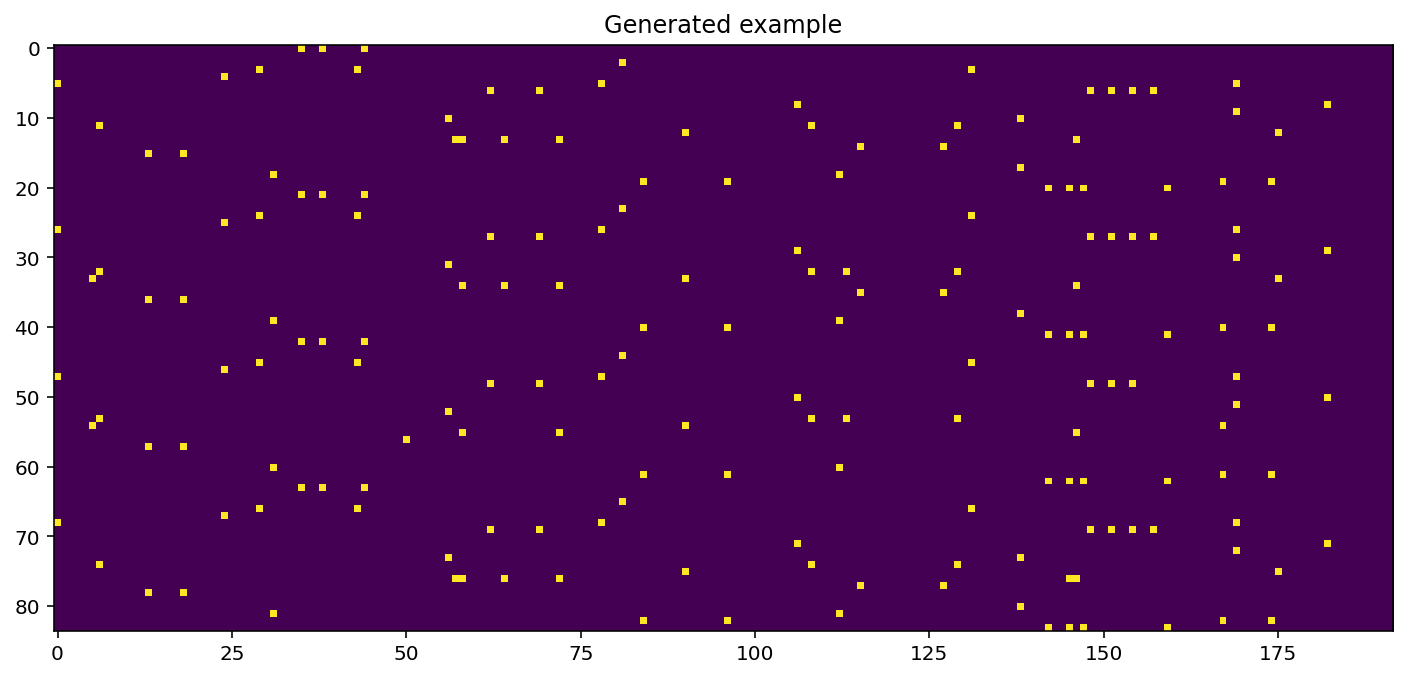

In [135]:
quick_test(lpd5Train.gen, lpd5Train.dis, lpd5, num_images = 3)